# Setup

In [25]:
!pip install --upgrade --force-reinstall --no-deps --quiet kaggle

     |████████████████████████████████| 58 kB 3.3 MB/s 


In [26]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [27]:
!kaggle competitions download -c tensorflow-great-barrier-reef -p /content/starfish

100% 14.2G/14.2G [02:34<00:00, 78.8MB/s]
100% 14.2G/14.2G [02:34<00:00, 98.7MB/s]


In [ ]:
!unzip /content/starfish/*.zip -d /content/starfish/

In [34]:
!rm /content/starfish/*.zip

# Dataset

In [117]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json

In [54]:
!ls /content/starfish

example_sample_submission.csv  greatbarrierreef  train.csv
example_test.npy	       test.csv		 train_images


In [57]:
train_df = pd.read_csv('/content/starfish/train.csv')

In [241]:
# 
# Get image dataset
#
# Note: Class = video_id
train_images_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/starfish/train_images/',
    validation_split=None,
    seed=123,
    image_size=(256,256),
    batch_size=1,
    label_mode=None
)
image_filepaths = train_images_ds.file_paths
train_images_ds = train_images_ds.map(lambda x: x / 255.0)

#
# Get filename dataset
#
# Note: filepath = /content/starfish/train_images/{video_id}/{video_frame}.jpg
train_fnames_ds = tf.data.Dataset.from_tensor_slices(image_filepaths)

#
# Get annotation dataset
#
# Note: image_id = {video_id}-{video_frame}
fpaths = image_filepaths
fpaths = [fpath.split('/content/starfish/train_images/')[1] for fpath in fpaths]
image_id = [fpath.split('/')[0][-1] + '-' + fpath.split('/')[1].split('.')[0] for fpath in fpaths]
df = train_df[['image_id', 'annotations']].set_index('image_id')
df = df.loc[image_id]
df = df['annotations'].apply(lambda x: json.loads(x.replace("'", '"')))
from collections import defaultdict
def process(x):
    # Format - (xmin, ymin, width, height)
    if len(x) == 0:
        out = []
    if len(x) == 1:
        out = x[0]
        out = [list(out.values())]
    if len(x) > 1:
        out = []
        for d in x:
            out.append(list(d.values()))
    return out

df = df.apply(lambda x: process(x))
df = tf.ragged.constant(df)
train_annotations_ds = tf.data.Dataset.from_tensor_slices(df)

#
# Combine datasets
#
train_ds = tf.data.Dataset.zip((train_fnames_ds, train_images_ds, train_annotations_ds))
train_ds = train_ds.map(lambda x,y,z: {'filename': x, 'image': y, 'annotations': z.to_tensor()})

Found 23501 files belonging to 1 classes.


In [242]:
next(iter(train_ds))

{'annotations': <tf.Tensor: shape=(0, 0), dtype=int32, numpy=array([], shape=(0, 0), dtype=int32)>,
 'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'/content/starfish/train_images/video_2/9675.jpg'>,
 'image': <tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.02034314, 0.36360294, 0.5133578 ],
          [0.01997549, 0.36789215, 0.49375   ],
          [0.03210784, 0.3408088 , 0.46348038],
          ...,
          [0.03884804, 0.2192402 , 0.32120097],
          [0.03137255, 0.23529412, 0.32941177],
          [0.04742647, 0.23137255, 0.33333334]],
 
         [[0.00281863, 0.42205882, 0.5726716 ],
          [0.00110294, 0.40061274, 0.5204657 ],
          [0.05269608, 0.34681374, 0.46838236],
          ...,
          [0.03419118, 0.2185049 , 0.32046568],
          [0.03529412, 0.23137255, 0.32941177],
          [0.03137255, 0.23529412, 0.32941177]],
 
         [[0.04963235, 0.54240197, 0.5942402 ],
          [0.04963235, 0.49485293, 0.55085784],
          [0.044

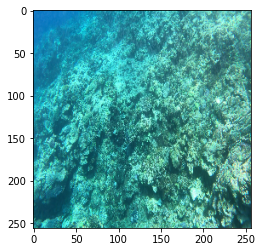

In [243]:
import matplotlib.pyplot as plt

sample = next(iter(train_ds))
plt.imshow(sample['image'][0])

# Model

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
# CNN
# In Image? or Not in Image?
# Push in side boundaries (relative %)
# Input - Image
# Output - In Image Flag? (Confidence)
# Output - % Change of respective boundary
# Loss - L2 Distance from True Boundary

In [40]:
basemodel = keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

16719872/16705208 [==============================] - 0s 0us/step
